批量规范化（batch normalization） (Ioffe and Szegedy, 2015)，是一种流行且有效的技术，可持续加速深层网络的收敛速度。

批量规范化的考量

首先，数据预处理的方式通常会对最终结果产生巨大影响。 

第二，对于典型的多层感知机或卷积神经网络。<br>
当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型的参数随着训练更新变幻莫测。 <br>
批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。 

内部协变量偏移：神经网络训练过程中，由于参数更新导致每一层输入分布不断变化的现象。简单来说，就是网络较浅层的参数变化使得较深层的输入分布发生改变，导致较深层需要不断适应这种分布变化。

第三，更深层的网络很复杂，容易过拟合。 这意味着正则化变得更加重要。

批量规范化应用于单个可选层（也可以应用到所有层），其原理如下：在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理(也就是当前网络中的batch_size)。 接下来，我们应用比例系数和比例偏移。 正是由于这个基于批量统计的标准化，才有了批量规范化的名称

如果我们尝试使用大小为1的小批量应用批量规范化，我们将无法学到任何东西。 这是因为在减去均值之后，每个隐藏单元将为0。 所以，只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。 

因此我们通常包含 拉伸参数（scale）$\gamma$ 和偏移参数（shift）$\beta$ ，它们的形状与 x 相同。 请注意，这两个数是需要与其他模型参数一起学习的参数。

批量规范化层在”训练模式“（通过小批量统计数据规范化）和“预测模式”（通过数据集统计规范化）中的功能不同。 在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。 而在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和方差(也就是整个训练集累积的移动平均统计量)。

作用：

加速网络收敛：通过标准化每一层的输入，减少了内部协变量偏移(internal covariate shift)，使得网络可以使用更高的学习率，显著加速训练过程。

提高训练稳定性：标准化过程使得每层输入分布更加稳定，减少了梯度消失和梯度爆炸问题。

稳定层间信号传递：减少了前层参数对后层的影响，使每层可以更独立地进行学习

具有正则化效果：由于使用小批量统计信息进行归一化，引入了一定的噪声，起到了轻微的正则化作用，有助于防止过拟合。

允许更深的网络结构：通过解决深层网络中的梯度问题，使得更深的网络结构成为可能。

因为批量规范化在完整的小批量上进行，因此不能像以前在引入其他层时那样忽略批量大小

全连接层：
将批量规范化置于全连接层中的仿射变换和激活函数中间

卷积层：
同样可以在卷积层之后和非线性激活函数之前应用批量规范化
当卷积有多个输出通道时，我们需要对这些通道的每个输出执行批量规范化，每个通道都有自己的拉伸和偏移参数，也就是每个通道有独立的归一化统计量，但通道内的所有空间位置和批次样本共享相同的统计量

预测过程中的批量规范化<br>
首先，将训练好的模型用于预测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。 其次，例如，我们可能需要使用我们的模型对逐个样本进行预测。 一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。 可见，和暂退法一样，批量规范化层在训练模式和预测模式下的计算结果也是不一样的。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 基本参数：X: 输入数据，gamma: 缩放参数，beta: 偏移参数， moving_mean: 移动平均的均值，moving_var: 移动平均的方差
# eps: 防止除零的极小值，momentum: 动量因子

# 动量参数在批量归一化中是一个关键的超参数，用于控制移动平均统计量(moving statistics)的更新速率。
# 决定了在更新移动平均统计量时，历史信息与当前批次信息的权衡比例。

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算

            # dim=(0, 2, 3): 指定沿哪些维度计算均值
            # keepdim=True: 保持输出张量的维度与输入一致（只是被平均的维度变为1）
            # 在除了通道维度以外的所有维度上计算均值（即批量、高度和宽度维度）
            # 对于每个通道，计算出该通道在整个批次、所有像素位置上的平均值
            # 由于 keepdim=True，结果将保持 4D 形状 [1, C, 1, 1]，而不是降维为 [C]

            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var

    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

现在可以创建一个正确的BatchNorm层。 这个层将保持适当的参数：拉伸gamma和偏移beta,这两个参数将在训练过程中更新。 此外，我们的层将保存均值和方差的移动平均值，以便在模型预测期间随后使用。

In [2]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

为了更好理解如何应用BatchNorm，下面我们将其应用于LeNet模型（ 6.6节）。 回想一下，批量规范化是在卷积层或全连接层之后、相应的激活函数之前应用的。 也就是Conv2d和sigmoid之间

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.257, train acc 0.905, test acc 0.734
22677.0 examples/sec on cuda:0


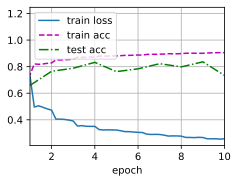

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

查看第一层中的拉伸参数和偏移参数

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.7513, 2.6118, 2.4108, 2.6312, 2.4291, 4.4839], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-2.2944,  3.0253, -1.8947,  1.3477,  2.4277,  2.5307], device='cuda:0',
        grad_fn=<ViewBackward0>))

也可以直接使用深度学习框架中的BatchNorm

In [ ]:
# nn.BatchNorm2d：
#     专门用于处理二维卷积特征图
#     在卷积神经网络中最常用
#     nn.BatchNorm2d(6) 中的 6 是指通道数(channels)，即卷积层输出的特征图的通道数

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.268, train acc 0.901, test acc 0.866
40773.9 examples/sec on cuda:0


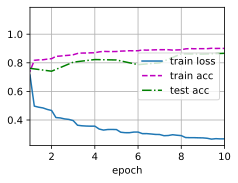

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())